# Interactive Data Exploration, Analysis, and Reporting (IDEAR) in Python for Azure Notebooks

- Author: Team Data Science Process Team from Microsoft 
- Date: 2017/03
- Supported Data Sources: CSV files in Azure blob storage

This is the **Interactive Data Exploration, Analysis and Reporting (IDEAR)** in _**Python**_ running on [Azure Notebooks](https://notebooks.azure.com/). The data can be CSV files in Azure Blob Storage. A yaml file has to be pre-configured and saved to Azure Blob Storage before running this tool.

## Running IDEAR Python using web browser in Azure Notebooks
This tool provides various functionalities to help users explore the data and get insights through interactive visualization and statistical testing using web browser in Azure Notebooks. You can run all the cells at once, when prompt, enter the yaml file and data file names.

- [Read and Summarize the data](#read and summarize)

- [Extract Descriptive Statistics of Data](#descriptive statistics)

- [Explore Individual Variables](#individual variables)

- [Explore Interactions between Variables](#multiple variables)

    - [Rank variables](#rank variables)
    
    - [Interaction between two categorical variables](#two categorical)
    
    - [Interaction between two numerical variables](#two numerical)

    - [Interaction between numerical and categorical variables](#numerical and categorical)

    - [Interaction between two numerical variables and a categorical variable](#two numerical and categorical)

- [Visualize High Dimensional Data via Projecting to Lower Dimension Principal Component Spaces](#pca)

After you are done with exploring the data interactively, you can choose to [show/hide the source code](#show hide codes) to make your notebook look neater. You may also download the analysis results as different formats such as PDF, HTML, markdown, etc. 

**Note**:

- Change the yaml file and save it to Azure blob storage before running IDEAR in Azure Notebooks.

## <a name="setup"></a> Global configuration and set up

In [1]:
import collections
from IPython.core.display import HTML
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
from functools import partial
import IPython
import ipywidgets
from ipywidgets import widgets
from ipywidgets import interact, interactive,fixed
import operator
from IPython.display import Javascript, display,HTML
from ipywidgets import widgets, VBox
import seaborn as sns
from collections import OrderedDict
from azure.storage.blob import BlobService
import yaml
import warnings
import getpass
import sys
warnings.filterwarnings('ignore')

class ConfUtility():   
    @staticmethod
    def parse_yaml(input_file):
        import yaml
        yaml_dict = {}
        with open (input_file,'r') as fin:
            try:
                yaml_dict = yaml.load(fin)
            except Exception as ex:
                print (ex)
        return yaml_dict

    @staticmethod
    def dict_to_htmllist(dc, include_list=None):
        dc2 = {}
        output_formatting = {'Target':'Target variable is ','CategoricalColumns':'Categorical Columns are ',
                           'NumericalColumns':'Numerical Columns are '}
        for each in dc.keys():
            if not include_list or each in include_list:
                if isinstance(dc[each],  collections.Iterable) and not isinstance(dc[each], str):
                    dc2[each] = ', \n'.join(val for val in dc[each])
                else:
                    dc2[each] = dc[each]
        html_list = "<ul>{}</ul>"
        html_list_entry = "<li>{}</li>"
        output3 = ''

        for each in set(include_list)|set(dc2.keys()):
            output3 += html_list_entry.format(output_formatting[each]+dc2[each])
        html_list = html_list.format(output3)
        return HTML(html_list)
    
class InteractionAnalytics():
    @staticmethod
    def rank_associations(df, conf_dict, col1, col2, col3):        
        try:
            col2 = int(col2)
            col3 = int(col3)
        except:
            pass
        
        # Passed Variable is Numerical
        if (col1 in conf_dict['NumericalColumns']) :
            fig,(ax1,ax2) = plt.subplots(1, 2)
            if len(conf_dict['NumericalColumns'])>1:
                
                # Interaction with numerical variables
                df2 = df[conf_dict['NumericalColumns']]
                corrdf = df2.corr()
                corrdf = abs(corrdf) 
                corrdf2 = corrdf[corrdf.index==col1].reset_index()[[each for each in corrdf.columns \
                                                      if col1 not in each]].unstack().sort_values(kind="quicksort", 
                                                                                                  ascending=False).head(col2)
                corrdf2 = corrdf2.reset_index()
                corrdf2.columns = ['level0','level1','rsq']
                corrdf2.set_index('level0', inplace=True)
                corrdf2[['rsq']].plot(kind='bar', ax=ax1)
                ax1.legend().set_visible(False)
                ax1.set_xlabel('Absolute Correlation')
                ax1.set_title('Top {} Associated Numeric Variables'.format(str(col2)))
                # Interaction with categorical variables
                etasquared_dict = {}
            if len(conf_dict['CategoricalColumns']) >= 1:
                for each in conf_dict['CategoricalColumns']:
                    mod = ols('{} ~ C({})'.format(col1, each),data=df[[col1,each]],missing='drop').fit()
                    aov_table = sm.stats.anova_lm(mod, typ=1)
                    esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
                    etasquared_dict[each] = esq_sm

                topk_esq = pd.DataFrame.from_dict(etasquared_dict, orient='index').unstack().sort_values(\
                    kind = 'quicksort', ascending=False).head(col3).reset_index().set_index('level_1')
                topk_esq.columns = ['level_0', 'EtaSquared']
                topk_esq[['EtaSquared']].plot(kind='bar',ax=ax2)
                ax2.legend().set_visible(False)
                ax2.set_xlabel('Eta-squared values')
                ax2.set_title('Top {}  Associated Categoric Variables'.format(str(col2)))
        # Passed Variable is Categorical
        else:
            #Interaction with numerical variables
            fig,(ax1,ax2) = plt.subplots(1,2)
            if len(conf_dict['NumericalColumns']) >= 1:
                etasquared_dict = {}
                for each in conf_dict['NumericalColumns']:
                    mod = ols('{} ~ C({})'.format(each, col1), data = df[[col1,each]]).fit()
                    aov_table = sm.stats.anova_lm(mod, typ=1)
                    esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
                    etasquared_dict[each] = esq_sm

                topk_esq = pd.DataFrame.from_dict(etasquared_dict, orient='index').unstack().sort_values(\
                    kind = 'quicksort', ascending=False).head(col2).reset_index().set_index('level_1')
                topk_esq.columns = ['level_0','EtaSquared']
                topk_esq[['EtaSquared']].plot(kind='bar',ax=ax1)
                ax1.legend().set_visible(False)
                ax1.set_xlabel('Eta-squared values')
                ax1.set_title('Top {} Associated Numeric Variables'.format(str(col2)))

            # Interaction with categorical variables
            cramer_dict = {}
            if len(conf_dict['CategoricalColumns'])>1:
                for each in conf_dict['CategoricalColumns']:
                    if each !=col1:
                        tbl = pd.crosstab(df[col1], df[each])
                        chisq = stats.chi2_contingency(tbl, correction=False)[0]
                        try:
                            cramer = np.sqrt(chisq/sum(tbl))
                        except:
                            cramer = np.sqrt(chisq/tbl.as_matrix().sum())
                            pass
                        cramer_dict[each] = cramer

                topk_cramer = pd.DataFrame.from_dict(cramer_dict, orient='index').unstack().sort_values(\
                    kind = 'quicksort', ascending=False).head(col3).reset_index().set_index('level_1')
                topk_cramer.columns = ['level_0','CramersV']
                topk_cramer[['CramersV']].plot(kind='bar',ax=ax2)
                ax2.legend().set_visible(False)
                ax2.set_xlabel("Cramer's V")
                ax2.set_title('Top {} Associated Categoric Variables'.format(str(col2)))
        
    @staticmethod
    def NoLabels(x):
        return ''
    
    @staticmethod
    def categorical_relations(df, col1, col2):
        if col1 != col2:
            df2 = df[(df[col1].isin(df[col1].value_counts().head(10).index.tolist()))&(df[col2].isin(df[col2].value_counts().head(10).index.tolist())) ]
            df3 = pd.crosstab(df2[col1], df2[col2])
            df3 = df3+1e-8
        else:
            df3 = pd.DataFrame(df[col1].value_counts())[:10]
        fig,ax = plt.subplots()
        fig,rects = mosaic(df3.unstack(),ax=ax, statistic=False, labelizer=InteractionAnalytics.NoLabels, label_rotation=30)
        ax.set_ylabel(col1)
        ax.set_xlabel(col2)
        ax.set_title('{} vs {}'.format(col1, col2) )
    
    @staticmethod
    def numerical_relations(df, col1, col2):
        from statsmodels.nonparametric.smoothers_lowess import lowess
        x = df[col2]
        y = df[col1]
        f, ax = plt.subplots(1)

        # lowess
        ax.scatter(x, y, c='g', s=6)
        lowess_results = lowess(y, x)#[:,1]
        xs = lowess_results[:, 0]
        ys = lowess_results[:, 1]
        ax.plot(xs,ys,'red',linewidth=1)

        #ols
        fit = np.polyfit(x, y, 1)
        fit1d = np.poly1d(fit)
        ax.plot(x, fit1d(x), '--b')
        ax.set_xlabel(col2)
        ax.set_ylabel(col1)
        corr = round(scipy.stats.pearsonr(x, y)[0], 6)
        ax.set_title('{} vs {}, Correlation {}'.format(col1, col2, corr))
    
    @staticmethod
    def numerical_correlation(df, conf_dict, col1):
        from matplotlib.pyplot import quiver, colorbar, clim,  matshow
        df2 = df[conf_dict['NumericalColumns']].corr(method=col1)
        col_names = list(df[conf_dict['NumericalColumns']].columns)
        fig,ax = plt.subplots(1, 1)
        m = ax.matshow(df2, cmap=matplotlib.pyplot.cm.coolwarm)
        ax.grid(b=False)
        fig.colorbar(m)
        ax.set_xticklabels([' '] + col_names) 
        ax.set_yticklabels([' '] + col_names)

    @staticmethod
    def numerical_pca(df, conf_dict, col1, col2, col3):
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        num_numeric = len(conf_dict['NumericalColumns'])
        num_pca = num_numeric
        xticklabels = ['']
        for i in range(1,num_pca+1):
            xticklabels+=['Comp'+str(i)]
            xticklabels+=['']
        df2 = df[conf_dict['NumericalColumns']]
        X = StandardScaler().fit_transform(df2.values)
        pca = PCA(n_components=num_pca)
        pca.fit(X)
        fig, (ax1,ax2) = plt.subplots(1, 2)
        ax1.bar(np.arange(1,(num_numeric+1),1),pca.explained_variance_ratio_ )
        ax1.set_ylabel('% Variance Explained')
        ax1.set_xticklabels(xticklabels)
        x_pca_index = int(col2) - 1
        y_pca_index = int(col3) - 1
        Y_pca = pd.DataFrame(pca.fit_transform(X))
        Y_pca_labels = []
        for i in range(1,num_pca+1):
            Y_pca_labels.append('PC'+str(i))
        Y_pca.columns = Y_pca_labels       
        Y_pca[col1] = df[col1]
        colors_dict = {}
        colors_list = ['r', 'y', 'c', 'y', 'k']
        j = 0
        for i in np.unique(df[col1]):
            colors_dict[i] = colors_list[j]
            j += 1
            if j == len(colors_list):
                j = 0
        colordf = pd.DataFrame.from_dict(colors_dict, orient='index').reset_index()
        colordf.columns = [col1, 'color']
        merged_df = pd.merge(colordf,Y_pca)
        grouped_df = merged_df.groupby(col1)
        for name, group in grouped_df:
            ax2.scatter(
               group[Y_pca.columns[x_pca_index]], group[Y_pca.columns[y_pca_index]],label=name,  
               c=group['color'],                            
               marker='o',                                
               s=6)                                       
        ax2.set_xlabel(Y_pca.columns[x_pca_index])
        ax2.set_ylabel(Y_pca.columns[y_pca_index])
        ax2.legend(title=col1, fontsize=14)
                
    @staticmethod
    def nc_relation(df, conf_dict, col1, col2, col3=None):
        fig,ax = plt.subplots()
        f = df[[col1,col2]].boxplot(by=col2, ax=ax)
        mod = ols('{} ~ {}'.format(col1, col2), data=df[[col1, col2]]).fit()
        aov_table = sm.stats.anova_lm(mod, typ=1)
        p_val = round(aov_table['PR(>F)'][0], 6)
        status = 'Passed'
        color = 'blue'
        if p_val < 0.05:
            status = 'Rejected'
            color = 'red'
        fig.suptitle('ho {} (p_value = {})'.format( status, p_val), color=color, fontsize=10)
    
    @staticmethod
    def pca_3d(df, conf_dict, col1, col2,  col3=None):
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        from mpl_toolkits.mplot3d import Axes3D
        df2 = df[conf_dict['NumericalColumns']]
        X = StandardScaler().fit_transform(df2.values)
        pca = PCA(n_components=4)
        pca.fit(X)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.view_init(elev=10, azim=int(col2))              
        Y_pca = pd.DataFrame(pca.fit_transform(X))
        Y_pca.columns = ['PC1','PC2','PC3','PC4']
        Y_pca[col1] = df[col1]
        colors_dict = {}
        colors_list = ['r', 'y', 'c', 'y', 'k']
        j = 0
        for i in np.unique(df[col1]):
            colors_dict[i] = colors_list[j]
            j += 1
            if j == len(colors_list):
                j = 0
        colordf = pd.DataFrame.from_dict(colors_dict, orient='index').reset_index()
        colordf.columns = [col1,'color']
        merged_df = pd.merge(colordf,Y_pca)
        grouped_df = merged_df.groupby(col1)
        for name, group in grouped_df:
            ax.scatter(
               group['PC1'], group['PC2'], group['PC3'], label=name,  
               c = group['color'],                            
               marker = 'o',                                
               s=6)                                      
        ax.set_xlabel('PC1', labelpad=18)
        ax.set_ylabel('PC2', labelpad=18)
        ax.set_zlabel('PC3', labelpad=18)
        ax.legend(title=col1, fontsize=10)

    @staticmethod
    def pca_3d_new(df, conf_dict, col1, col2, col3, col4, col5):
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        from mpl_toolkits.mplot3d import Axes3D
        df2 = df[conf_dict['NumericalColumns']]
        X = StandardScaler().fit_transform(df2.values)
        num_numeric = len(conf_dict['NumericalColumns'])
        pca = PCA(n_components=num_numeric)
        pca.fit(X)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.view_init(elev=10, azim=int(col5))                 
        Y_pca = pd.DataFrame(pca.fit_transform(X))
        Y_pca_names = []
        for i in range(1, num_numeric+1):
            Y_pca_names.append('PC'+str(i))
        Y_pca.columns = Y_pca_names
        Y_pca[col1] = df[col1]
        colors_dict = {}
        colors_list = ['r', 'y', 'c', 'y', 'k']
        j = 0
        for i in np.unique(df[col1]):
            colors_dict[i] = colors_list[j]
            j += 1
            if j == len(colors_list):
                j = 0
        colordf = pd.DataFrame.from_dict(colors_dict, orient='index').reset_index()
        colordf.columns = [col1,'color']
        merged_df = pd.merge(colordf,Y_pca)
        grouped_df = merged_df.groupby(col1)
        for name, group in grouped_df:
            ax.scatter(
               group[Y_pca_names[int(col2)-1]], group[Y_pca_names[int(col3)-1]], group[Y_pca_names[int(col4)-1]], label=name,  
               c = group['color'],                            
               marker = 'o',                                
               s=6)
        ax.set_xlabel(Y_pca_names[int(col2)-1], labelpad=18)
        ax.set_ylabel(Y_pca_names[int(col3)-1], labelpad=18)
        ax.set_zlabel(Y_pca_names[int(col4)-1], labelpad=18)
        ax.legend(title=col1, fontsize=10)
        
    @staticmethod
    def nnc_relation(df, conf_dict, col1, col2, col3):
        import itertools
        markers = ['x', 'o', '^']
        color = itertools.cycle(['r', 'y', 'c', 'y', 'k']) 
        groups = df[[col1, col2, col3]].groupby(col3)

        # Plot
        fig, ax = plt.subplots()
        ax.margins(0.05) 

        for (name, group), marker in zip(groups, itertools.cycle(markers)):
            ax.plot(group[col1], group[col2], marker='o', linestyle='', ms=4, label=name)
        ax.set_xlabel(col1)
        ax.set_ylabel(col2)
        ax.legend(numpoints=1, loc='best', title=col3)
        
class TargetAnalytics():
    ReportedVariables = []
    @staticmethod
    def custom_barplot(df, col1=''):
        f, (ax0,ax1) = plt.subplots(1, 2)
        df[col1].value_counts().plot(ax=ax0, kind='bar')
        ax0.set_title('Bar Plot of {}'.format(col1))
        df[col1].value_counts().plot(ax=ax1, kind='pie')
        ax1.set_title('Pie Chart of {}'.format(col1))

class NumericAnalytics():
    @staticmethod
    def shapiro_test(x):
        p_val = round(stats.shapiro(x)[1],6)
        status = 'passed'
        color = 'blue'
        if p_val < 0.05:
            status = 'failed'
            color = 'red'
        return status, color, p_val

    @staticmethod
    def custom_barplot(df, col1=''):
        fig, axes = plt.subplots(2,2)
        axes = axes.reshape(-1)
        df[col1].plot(ax=axes[0], kind='hist')
        axes[0].set_title('Histogram of {}'.format(col1))
        df[col1].plot(ax=axes[1], kind='kde')
        axes[1].set_title('Density Plot of {}'.format(col1))
        ax3 = plt.subplot(223)
        stats.probplot(df[col1], plot=plt)
        axes[2].set_title('QQ Plot of {}'.format(col1))
        df[col1].plot(ax=axes[3], kind='box')
        axes[3].set_title('Box Plot of {}'.format(col1))
        status, color, p_val = NumericAnalytics.shapiro_test(df[col1])
        fig.suptitle('Normality test for {} {} (p_value = {})'.format(col1, status, round(p_val, 6)), color=color, fontsize=12)
    
class CategoricAnalytics():
    @staticmethod
    def custom_barplot(df, col1=''):
        f, (ax0,ax1) = plt.subplots(1,2)
        df[col1].value_counts().nlargest(10).plot(ax=ax0, kind='bar')
        ax0.set_xlabel(col1)
        ax0.set_title('Bar chart of {}'.format(col1))
        df[col1].value_counts().nlargest(10).plot(ax=ax1, kind='pie')
        ax1.set_title('Pie chart of {}'.format(col1))
 
%matplotlib inline
font={'family':'normal','weight':'normal','size':8}
matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12.0, 5.0)
matplotlib.rc('xtick', labelsize=9) 
matplotlib.rc('ytick', labelsize=9)
matplotlib.rc('axes', labelsize=10)
matplotlib.rc('axes', titlesize=10)
sns.set_style('whitegrid')

### Set up connection to Azure Blob Storage

In [2]:
#Connection String
blob_service = BlobService(account_name=getpass.getpass('Please enter Azure Storage Account Name:'),account_key=getpass.getpass('Please enter Azure Storage Account Key:'))
container_name = getpass.getpass('Please enter Container Name:')

Please enter Azure Storage Account Name:Â·Â·Â·Â·Â·Â·Â·Â·
Please enter Azure Storage Account Key:Â·Â·Â·Â·Â·Â·Â·Â·
Please enter Container Name:Â·Â·Â·Â·Â·Â·Â·Â·


### Specify and load yaml file

In [3]:
#Read in yaml file as text
if (sys.version_info > (3, 0)):    
    yaml_file_name = input('Please enter yaml file Name: ')
else:
    yaml_file_name = raw_input('Please enter yaml file Name: ')
    
yaml_data = blob_service.get_blob(container_name,yaml_file_name)
conf_dict = yaml.load(yaml_data)
data_file_name = conf_dict['DataFilePath'][0]
print("The data set is: {} ".format(data_file_name))

Please enter yaml file Name: para-adult.yaml
The data set is: adult-income.csv 


## <a name="read and summarize"></a> Read and Summarize the Data

### Load data from Azure Blob Storage

In [4]:
#Read in data as text
data = blob_service.get_blob_to_text(container_name,data_file_name).split("\n")

print ('{} rows have been read in from Azure Blob Storage.'.format(len(data)))

#convert to df
df = pd.DataFrame([sub.split(",") for sub in data[1:]], columns = data[0].split(","))

#remove the space in column names
df.columns = [x.strip().replace(' ', '') for x in df.columns]

#change numeric columns to numeric
df[conf_dict['NumericalColumns']] = df[conf_dict['NumericalColumns']].apply(pd.to_numeric)

32562 rows have been read in from Azure Blob Storage.


### Read data and infer column types

In [5]:
# Define sample size
Sample_Size = 10000
    
# Making sure that we are not reading any extra column
df = df[[each for each in df.columns if 'Unnamed' not in each]]

# Sampling Data if data size is larger than 10k
df0 = df # df0 is the unsampled data. Will be used in data exploration and analysis where sampling is not needed
         # However, keep in mind that your final report will always be based on the sampled data. 
if Sample_Size < df.shape[0]:
    df = df.sample(Sample_Size)

# Getting the list of categorical columns if it was not there in the yaml file
if 'CategoricalColumns' not in conf_dict:
    conf_dict['CategoricalColumns'] = list(set(list(df.select_dtypes(exclude=[np.number]).columns)))

# Getting the list of numerical columns if it was not there in the yaml file
if 'NumericalColumns' not in conf_dict:
    conf_dict['NumericalColumns'] = list(df.select_dtypes(include=[np.number]).columns)    

# Exclude columns that we do not need
if 'ColumnsToExclude' in conf_dict:
    conf_dict['CategoricalColumns'] = list(set(conf_dict['CategoricalColumns'])-set(conf_dict['ColumnsToExclude']))
    conf_dict['NumericalColumns'] = list(set(conf_dict['NumericalColumns'])-set(conf_dict['ColumnsToExclude']))

# Ordering the categorical variables according to the number of unique categories
filtered_cat_columns = []
temp_dict = {}

for cat_var in conf_dict['CategoricalColumns']:
    temp_dict[cat_var] = len(np.unique(df[cat_var]))

sorted_x = sorted(temp_dict.items(), key=operator.itemgetter(0), reverse=True)
conf_dict['CategoricalColumns'] = [x for (x,y) in sorted_x]
ConfUtility.dict_to_htmllist(conf_dict,['Target','CategoricalColumns','NumericalColumns'])

### Print the first n (n=5 by default) rows of the data

In [6]:
def custom_head(df,NoOfRows):
    return HTML(df.head(NoOfRows).style.set_table_attributes("class='table'").render())
i = interact(custom_head,df=fixed(df0), NoOfRows=ipywidgets.IntSlider(min=0, max=30, step=1, value=5, description='Number of Rows'))

### Print the dimensions of the data (rows, columns)

In [7]:
print ('The data has {} Rows and {} columns'.format(df0.shape[0],df0.shape[1]))

The data has 32561 Rows and 15 columns


### Print the column names of the data

In [8]:
col_names = ','.join(each for each in list(df.columns))
print("The column names are:" + col_names)

The column names are:age,workclass,fnlwgt,education,educationnum,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,label_IsOver50K


### Print the column types

In [9]:
print("The types of columns are:")
df.dtypes

The types of columns are:


age                 int64
workclass          object
fnlwgt              int64
education          object
educationnum        int64
maritalstatus      object
occupation         object
relationship       object
race               object
sex                object
capitalgain         int64
capitalloss         int64
hoursperweek        int64
nativecountry      object
label_IsOver50K    object
dtype: object

## <a name="descriptive statistics"></a>Extract Descriptive Statistics of Each Column

In [10]:
def num_missing(x):
    return len(x.index)-x.count()

def num_unique(x):
    return len(np.unique(x))

temp_df = df0.describe().T
missing_df = pd.DataFrame(df0.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']
unq_df = pd.DataFrame(df0.apply(num_unique, axis=0))
unq_df.columns = ['unique']
types_df = pd.DataFrame(df0.dtypes)
types_df.columns = ['DataType']

### Print the descriptive statistics of numerical columns

In [11]:
summary_df = temp_df.join(missing_df).join(unq_df).join(types_df)
summary_df

,count,mean,std,min,25%,50%,75%,max,missing,unique,DataType
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0,0,73,int64
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0,0,21648,int64
educationnum,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0,0,16,int64
capitalgain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0,0,119,int64
capitalloss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0,0,92,int64
hoursperweek,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0,0,94,int64


### Print the descriptive statistics of categorical columns

In [12]:
col_names = list(types_df.index)
num_cols = len(col_names)
index = range(num_cols)
cat_index = []
for i in index:
    if col_names[i] in conf_dict['CategoricalColumns']:
        cat_index.append(i)
summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner') #Only summarize categorical columns
summary_df_cat

,missing,unique,DataType
workclass,0,9,object
education,0,16,object
maritalstatus,0,7,object
occupation,0,15,object
relationship,0,6,object
race,0,5,object
sex,0,2,object
nativecountry,0,42,object
label_IsOver50K,0,2,object


## <a name="individual variables"></a>Explore Individual Variables

### Explore the target variable

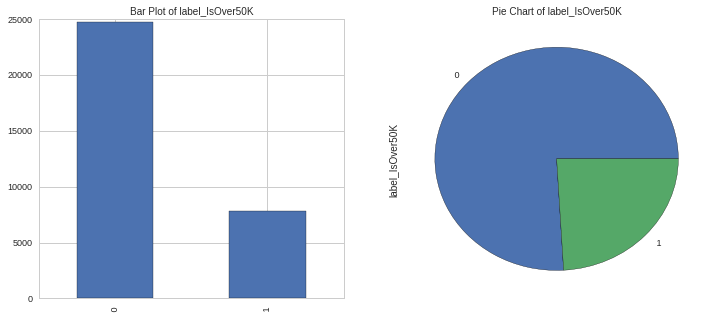

In [13]:
if conf_dict['Target'] in conf_dict['CategoricalColumns']:
    w1_value = ''
    w1 = None  
    w1 = widgets.Dropdown(
        options=[conf_dict['Target']],
        value=conf_dict['Target'],
        description='Target Variable:',
    )
    i = interactive(TargetAnalytics.custom_barplot, df=fixed(df), col1=w1)
    hbox = widgets.HBox(i.children[:1])
    display(hbox)
    hbox.on_displayed(TargetAnalytics.custom_barplot(df=df0, col1=w1.value))
else:
    w1_value = ''
    w1 = None
    w1 = widgets.Dropdown(
            options=[conf_dict['Target']],
            value=conf_dict['Target'],
            description='Target Variable:',
        )
    i = interactive(NumericAnalytics.custom_barplot, df=fixed(df), col1=w1)
    hbox = widgets.HBox(i.children)
    display(hbox)
    hbox.on_displayed(NumericAnalytics.custom_barplot(df=df, col1=w1.value))

### Explore individual numeric variables and test for normality (on sampled data)

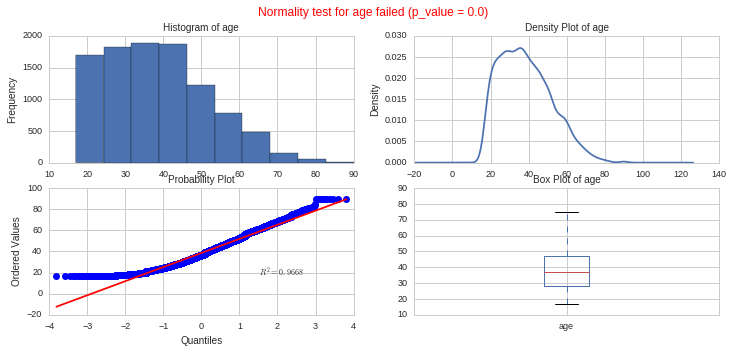

In [14]:
w1_value = ''
w1 = None
w1 = widgets.Dropdown(
        options=conf_dict['NumericalColumns'],
        value=conf_dict['NumericalColumns'][0],
        description='Numeric Variable:',
    )

i = interactive(NumericAnalytics.custom_barplot, df=fixed(df), col1=w1)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(NumericAnalytics.custom_barplot(df=df, col1=w1.value))

### Explore individual categorical variables (sorted by frequencies)

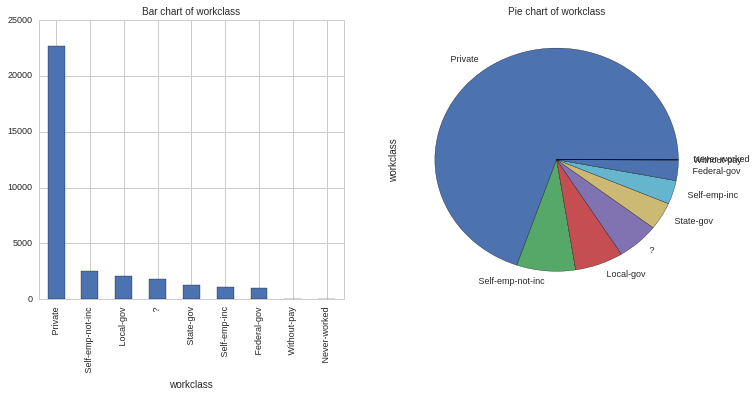

In [15]:
w1_value = ''
w1 = None

w1 = widgets.Dropdown(
    options = conf_dict['CategoricalColumns'],
    value = conf_dict['CategoricalColumns'][0],
    description = 'Categorical Variable:',
)


i = interactive(CategoricAnalytics.custom_barplot, df=fixed(df), col1=w1)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(CategoricAnalytics.custom_barplot(df=df0, col1=w1.value))

## <a name="multiple variables"></a>Explore Interactions Between Variables

### <a name="rank variables"></a>Rank variables based on linear relationships with reference variable (on sampled data)

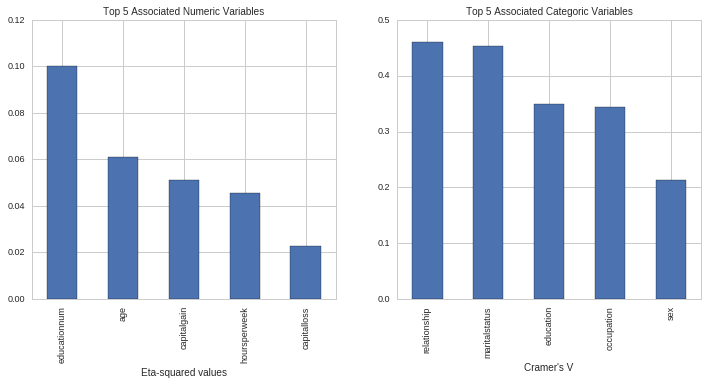

In [16]:
cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] + conf_dict['CategoricalColumns'] 
cols_list = list(OrderedDict.fromkeys(cols_list)) 
w1 = widgets.Dropdown(    
    options=cols_list,
    value=cols_list[0],
    description='Ref Var:'
)
w2 = ipywidgets.Text(value="5", description='Top Num Vars:')
w3 = ipywidgets.Text(value="5", description='Top Cat Vars:')
i = interactive(InteractionAnalytics.rank_associations, df=fixed(df),conf_dict=fixed(conf_dict), col1=w1, col2=w2, col3=w3)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.rank_associations(df=df, conf_dict=conf_dict, col1=w1.value, col2=w2.value, col3=w3.value))

### <a name="two categorical"></a>Explore interactions between categorical variables

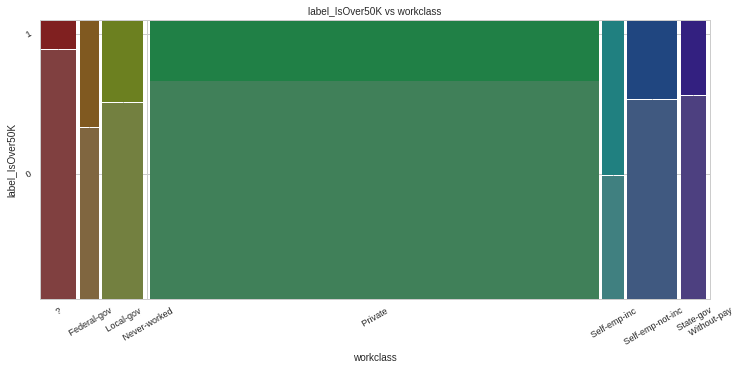

In [17]:
w1, w2 = None, None

if conf_dict['Target'] in conf_dict['CategoricalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] 
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = conf_dict['CategoricalColumns']
    
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Categorical Var 1:'
)
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[1],
    description='Categorical Var 2:'
)

i = interactive(InteractionAnalytics.categorical_relations, df=fixed(df), col1=w1, col2=w2)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.categorical_relations(df=df0, col1=w1.value, col2=w2.value))

### <a name="two numerical"></a>Explore interactions between numerical variables (on sampled data)

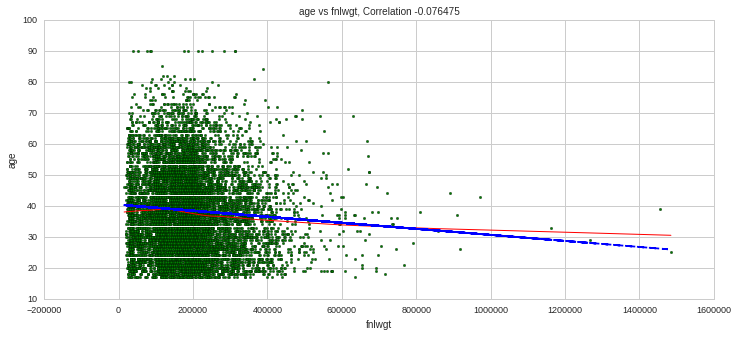

In [18]:
w1, w2 = None, None

if conf_dict['Target'] in conf_dict['NumericalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] 
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = conf_dict['NumericalColumns']
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Numerical Var 1:'
)
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[1],
    description='Numerical Var 2:'
)
i = interactive(InteractionAnalytics.numerical_relations, df=fixed(df), col1=w1, col2=w2)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.numerical_relations(df, col1=w1.value, col2=w2.value))

### Explore correlation matrix between numerical variables

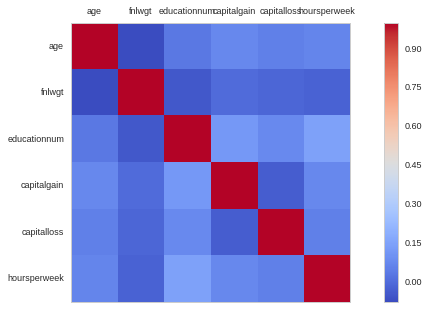

In [19]:
w1 = None
w1 = widgets.Dropdown(
    options=['pearson','kendall','spearman'],
    value='pearson',
    description='Correlation Method:'
)
i = interactive(InteractionAnalytics.numerical_correlation, df=fixed(df), conf_dict=fixed(conf_dict), col1=w1)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.numerical_correlation(df0, conf_dict=conf_dict, col1=w1.value))

### <a name="numerical and categorical"></a>Explore interactions between numerical and categorical variables

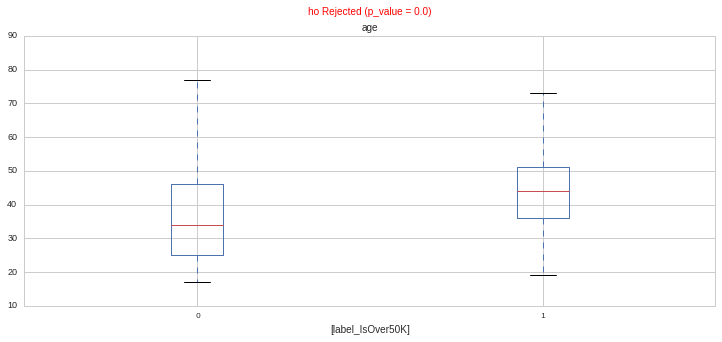

In [20]:
w1, w2 = None, None

if conf_dict['Target'] in conf_dict['NumericalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['NumericalColumns']
    
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Numerical Variable:'
)

if conf_dict['Target'] in conf_dict['CategoricalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] #Make target the default reference variable
    cols_list = list(OrderedDict.fromkeys(cols_list)) #remove variables that might be duplicates with target
else:
    cols_list = conf_dict['CategoricalColumns']
    
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Categorical Variable:'
)
i = interactive(InteractionAnalytics.nc_relation, df=fixed(df),conf_dict=fixed(conf_dict), col1=w1, col2=w2, col3=fixed(w3))
hbox = widgets.HBox(i.children)
display( hbox )
hbox.on_displayed(InteractionAnalytics.nc_relation(df0, conf_dict, col1=w1.value, col2=w2.value))

### <a name="two numerical and categorical"></a>Explore interactions between two numerical variables and a categorical variable (on sampled data)

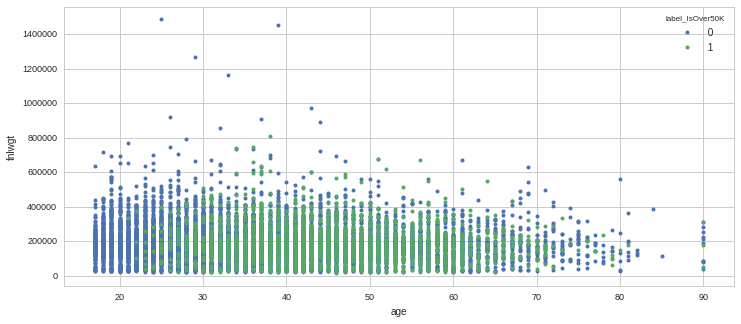

In [21]:
w1, w2, w3 = None, None, None

if conf_dict['Target'] in conf_dict['NumericalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['NumericalColumns'] 
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = conf_dict['NumericalColumns']
    
w1 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[0],
    description = 'Numerical Var 1:'
)
w2 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[1],
    description = 'Numerical Var 2:'
)

if conf_dict['Target'] in conf_dict['CategoricalColumns']:
    cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] 
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = conf_dict['CategoricalColumns']
    
w3 = widgets.Dropdown(
    options = cols_list,
    value = cols_list[0],
    description = 'Legend Cat Var:'
)
i = interactive(InteractionAnalytics.nnc_relation, df=fixed(df),conf_dict=fixed(conf_dict), col1=w1, col2=w2, col3=w3)
hbox = widgets.HBox(i.children)
display(hbox)
hbox.on_displayed(InteractionAnalytics.nnc_relation(df, conf_dict, col1=w1.value,col2=w2.value, col3=w3.value))

## <a name="pca"></a>Visualize numerical data by projecting to principal component spaces (on sampled data)

### Project data to 2-D principal component space (on sampled data)

/home/nbuser/anaconda3_410/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


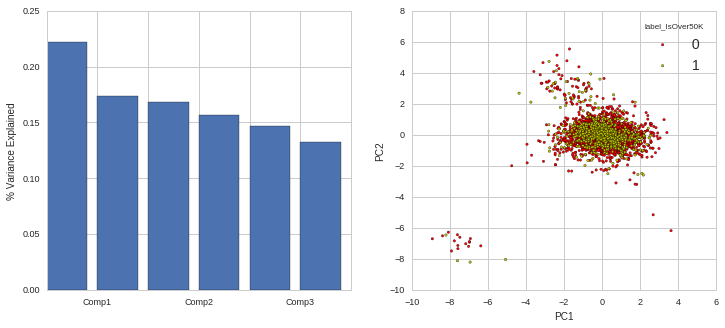

In [22]:
num_numeric = len(conf_dict['NumericalColumns'])
if  num_numeric > 3:
    
    w1, w2, w3 = None, None, None
    if conf_dict['Target'] in conf_dict['CategoricalColumns']:
        cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] 
        cols_list = list(OrderedDict.fromkeys(cols_list)) 
    else:
        cols_list = conf_dict['CategoricalColumns']
    w1 = widgets.Dropdown(
        options = cols_list,
        value = cols_list[0],
        description = 'Legend Variable:',
        width = 10
    )
    w2 = widgets.Dropdown(
        options = [str(x) for x in np.arange(1,num_numeric+1)],
        value = '1',
        width = 1,
        description='PC at X-Axis:'
    )
    w3 = widgets.Dropdown(
        options = [str(x) for x in np.arange(1,num_numeric+1)],
        value = '2',
        description = 'PC at Y-Axis:'
    )
    i = interactive(InteractionAnalytics.numerical_pca, df=fixed(df),conf_dict=fixed(conf_dict), col1=w1, col2=w2, col3=w3)
    hbox = widgets.HBox(i.children[:3])
    display(hbox)
    hbox.on_displayed(InteractionAnalytics.numerical_pca(df, conf_dict=conf_dict, col1=w1.value, col2=w2.value, col3=w3.value))

### Project data to 3-D principal component space (on sampled data)

/home/nbuser/anaconda3_410/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


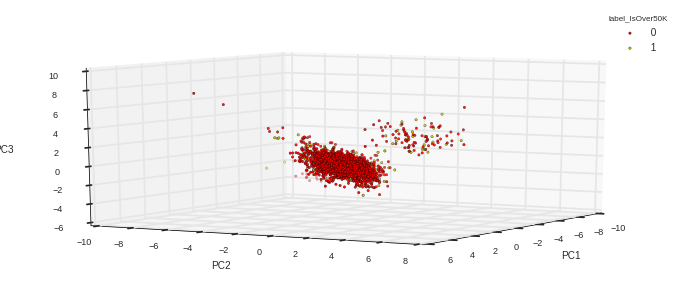

In [23]:
if len(conf_dict['NumericalColumns']) > 3:
    if conf_dict['Target'] in conf_dict['CategoricalColumns']:
        cols_list = [conf_dict['Target']] + conf_dict['CategoricalColumns'] 
        cols_list = list(OrderedDict.fromkeys(cols_list)) 
    else:
        cols_list = conf_dict['CategoricalColumns']
    w1, w2 = None, None
    w1 = widgets.Dropdown(
        options=cols_list,
        value=cols_list[0],
        description='Legend Variable:'
    )
    w2 = ipywidgets.IntSlider(min=-180, max=180, step=5, value=30, description='Angle')
    i = interactive(InteractionAnalytics.pca_3d, df=fixed(df), conf_dict=fixed(conf_dict),col1=w1, col2=w2, col3=fixed(w3))
    hbox=widgets.HBox(i.children[:2])
    display(hbox)
    hbox.on_displayed(InteractionAnalytics.pca_3d(df,conf_dict,col1=w1.value,col2=w2.value))

## <a name="show hide codes"></a>Show/Hide the Source Codes

In [24]:
display(HTML('''<style>
    .widget-label { min-width: 20ex !important; }
    .widget-text { min-width: 60ex !important; }
</style>'''))

#Toggle Code
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();

 } else {
 $('div.input').show();

 }
 code_show = !code_show
} 
//$( document ).ready(code_toggle);//commenting code disabling by default
</script>
<form action = "javascript:code_toggle()"><input type="submit" value="Toggle Raw Code"></form>''')